# Udacity Self-Driving Car Nanodegree Program

## Advanced Lane Finding Project

The steps involved in this project are:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### Imports

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Camera Calibration

Given different chessboard images, find the object and image points for calibrating the camera.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6

def find_img_obj_points():
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    return objpoints, imgpoints

In [3]:
def calibrate_camera(objpoints, imgpoints):
    # Test undistortion on an image
    img = cv2.imread('test_images/test1.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    save_matrices(mtx, dist)
    return mtx, dist
    
def undistort_img(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    
def save_matrices(mtx, dist):
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ))

## Function to load the images

loads test images, camera calibration images, image frames from project Videos

In [4]:
test_images = 'test_images/*.jpg'
camera_calibration_images = 'camera_cal/*.jpg'        
TEST = 'test'
CAM_CAL = 'camera_calibration'

def load_images(image_type):
    if image_type == TEST:
        glob_regex = 'test_images/*.jpg'
    elif image_type == CAM_CAL:
        glob_regex = 'camera_cal/*.jpg'
    else:
        print('Invalid Type')
        return
    images=[]
    for f in glob.glob(glob_regex):
  
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images

## Visualization Module

function to visualize diferent types transformations on the images

In [5]:
UNDISTORT_TRANSFORM = 'undistort_transform'
PERSPECTIVE_TRANSFORM = 'perspective_transform'
SOBEL_ABSOLUTE_TRANSFORM = 'sobel_abs'
SOBEL_MAGNITUDE_TRANSFORM = 'sobel_mag'
SOBEL_DIRECTIONAL_TRANSFORM = 'sobel_dir'
SOBEL_COMBINED_TRANSFORM = 'sobel_combined'
HLS_S_TRANSFORM = 'hls_s_transform'
HLS_L_TRANSFORM = 'hls_l_transform'
LAB_B_TRANSFORM = 'lab_b_transform'
SOBEL_COMBINED_ALL_TRANSFORM = 'sobel_all_combined'
PIPELINE_TRANSFORM = 'pipeline'
PLOT_PIPELINE_TRANSFORM = 'plot_pipeline'
PLOT_PREV_PIPELINE_TRANSFORM = 'plot_prev_transform'
PLOT_LANE_TRANSFORM = 'plot_lane_transform'
PLOT_LANE_DATA_TRANSFORM = 'plot_lane_data_transform'

def visualize_transformation(images, transform_type, visualize_lines = False):
    n = len(images)
    
    def view_image(i):
        file, img = images[i]
        
        if transform_type == UNDISTORT_TRANSFORM:    
            dst_img = undistort_img(img)
        elif transform_type == PERSPECTIVE_TRANSFORM:
            undistorted_img = undistort_img(img)
            dst_img, _, _ = perspective_transform(undistorted_img, src, dst)
            
        if visualize_lines == True:
            draw_lines(img,src)
            draw_lines(dst_img,dst)
            
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img)
        ax2.set_title('Transformed Image', fontsize=30)
        
    def view_image_abs(i, min_thresh, max_thresh):
        file, img = images[i]
    
        if transform_type == SOBEL_ABSOLUTE_TRANSFORM:
            undistorted_img = undistort_img(img)
            #p_transformed_img, _, _ = perspective_transform(undistorted_img, src, dst)
            dst_img = abs_sobel_thresh(undistorted_img, 'x', min_thresh, max_thresh)
                 
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img, cmap = 'gray')
        ax2.set_title('Absolute Sobel', fontsize=30)
        
    def view_image_mag(i, min_thresh, max_thresh, kernel):
        file, img = images[i]
    
        if transform_type == SOBEL_MAGNITUDE_TRANSFORM:
            undistorted_img = undistort_img(img)
            dst_img = mag_thresh(undistorted_img, kernel, (min_thresh, max_thresh))
                 
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img, cmap = 'gray')
        ax2.set_title('Magnitude Sobel', fontsize=30)
        
    def view_image_dir(i, min_thresh, max_thresh, kernel):
        file, img = images[i]
    
        if transform_type == SOBEL_DIRECTIONAL_TRANSFORM:
            undistorted_img = undistort_img(img)
            dst_img =  dir_thresh(undistorted_img, kernel, (min_thresh, max_thresh))
                 
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img, cmap = 'gray')
        ax2.set_title('Directional Sobel', fontsize=30)
        
    def view_image_combined(i, mag_kernel, mag_min_thresh, mag_max_thresh, 
                            dir_kernel, dir_min_thresh, dir_max_thresh):
        file, img = images[i]
    
        if transform_type == SOBEL_COMBINED_TRANSFORM:
            undistorted_img = undistort_img(img)
            img_sobel_mag = mag_thresh(undistorted_img, mag_kernel, (mag_min_thresh, mag_max_thresh))
            img_sobel_dir = dir_thresh(undistorted_img, dir_kernel, (dir_min_thresh, dir_max_thresh))
            dst_img = np.zeros_like(img_sobel_mag)
            dst_img[((img_sobel_mag == 1) & (img_sobel_dir == 1))] = 1
                 
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img, cmap = 'gray')
        ax2.set_title('Magnitude+Directional Sobel', fontsize=30)
        
    def view_image_all_combined(i, abs_min_thresh, abs_max_thresh, mag_kernel, 
                                mag_min_thresh, mag_max_thresh, 
                            dir_kernel, dir_min_thresh, dir_max_thresh, 
                                hls_l_min_thresh, hls_l_max_thresh, lab_b_min_thresh, 
                                lab_b_max_thresh):
        file, img = images[i]
    
        if transform_type == SOBEL_COMBINED_ALL_TRANSFORM:
            undistorted_img = undistort_img(img)
            p_transformed_img, _, _ = perspective_transform(undistorted_img, src, dst)
            
            plt.imshow(p_transformed_img)
            
            #img_sobel_abs = abs_sobel_thresh(p_transformed_img, (abs_min_thresh, abs_max_thresh))  
            img_sobel_mag = mag_thresh(p_transformed_img, mag_kernel, (mag_min_thresh, mag_max_thresh))
            img_sobel_dir = dir_thresh(p_transformed_img, dir_kernel, (dir_min_thresh, dir_max_thresh))
            
            img_sobel_combined = np.zeros_like(img_sobel_mag)
            #img_sobel_combined[((img_sobel_mag == 1) & (img_sobel_dir == 1) & (img_sobel_abs == 1))] = 1
            img_sobel_combined[((img_sobel_mag == 1) & (img_sobel_dir == 1))] = 1
            
            img_hls_l = hls_lthresh(p_transformed_img, (hls_l_min_thresh, hls_l_max_thresh))
            img_lab_b = lab_bthresh(p_transformed_img, (lab_b_min_thresh,  lab_b_max_thresh))
            
            dst_img = np.zeros_like(img_lab_b)
            dst_img[(img_hls_l == 1) | (img_lab_b == 1) | (img_sobel_combined==1) ] = 1
                 
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img, cmap = 'gray')
        ax2.set_title('Combined Threshold', fontsize=30)
        
    def view_pipeline_img(i):
        file, img = images[i]
        #print(img.shape)
        dst_img, _ = pipeline(img)
        dst_img_color, __ = pipeline_color(img)
         # Visualize transformation
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img, cmap = 'gray')
        ax2.set_title('Combined threshold', fontsize=30)
        ax3.imshow(dst_img_color, cmap = 'gray')
        ax3.set_title('Comined color threshold', fontsize=30)
        
    def view_plot_pipeline_img(i):
        file, img = images[i]
        #print(img.shape)
        img, _ = pipeline_color(img)
        dst_img, ploty, left_fit, right_fit, hist = plot_pipeline(img)
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Visualize transformation
        fig, axs = plt.subplots(1,3, figsize=(20,10))
        #fig.subplots_adjust(hspace = .8, wspace=.1)
        axs = axs.ravel()
        axs[0].imshow(img)
        axs[0].set_title('Original Image', fontsize=15)
        axs[1].imshow(dst_img)
        axs[1].set_title('Image with fitted lane plotted', fontsize=15)
        axs[1].plot(left_fitx, ploty, color='yellow')
        axs[1].plot(right_fitx, ploty, color='yellow')
        axs[2].plot(hist)
        
    def view_plot_prev_pipeline_img(i):
        file, img = images[i]
        # visualize the result on example image
        plt.imshow(img)
        #img, _ = pipeline(img)
        result, ploty, fit = plot_prev_fit_pipeline(img)
        left_fit2 = fit[0]
        right_fit2 = fit[1]
        left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
        right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]
        
        # Visualize transformation
        fig, axs = plt.subplots(1,2, figsize=(20,10))
        fig.subplots_adjust(hspace = .8, wspace=.1)
        axs = axs.ravel()
        axs[0].imshow(img)
        axs[0].set_title('Original Image', fontsize=15)
        axs[1].imshow(result)
        axs[1].set_title('Image using lane fit from previous frame', fontsize=15)
        axs[1].plot(left_fitx2, ploty, color='yellow')
        axs[1].plot(right_fitx2, ploty, color='yellow')
        #axs[1].xlim(0, 1280)
        #axs[1].ylim(720, 0)
        
    def view_plotted_lane_img(i):
        file, img = images[i]
        #print('file-->', file)
        # visualize the result on example image
        #plt.imshow(img)
        out_img, Minv = pipeline_color(img)
        _, __, left_fit, right_fit, ___ = plot_pipeline(out_img)
        dst_img = draw_lane(img, out_img, left_fit, right_fit, Minv)
        
        # Visualize transformation
        fig, axs = plt.subplots(1,2, figsize=(20,10))
        fig.subplots_adjust(hspace = .8, wspace=.1)
        axs = axs.ravel()
        axs[0].imshow(img)
        axs[0].set_title('Original Image', fontsize=15)
        axs[1].imshow(dst_img)
        axs[1].set_title('Lane Plotted Image', fontsize=15)
        
    def view_plotted_lane_data_img(i):
        
        file, img = images[i]
        out_img, Minv = pipeline_color(img)
        fit, lane_inds, visualization_data = lane_polyfit(out_img)
        left_fit = fit[0]
        right_fit = fit[1]
        left_lane_inds = lane_inds[0]
        right_lane_inds = lane_inds[1]
        lane_img = draw_lane(img, out_img, left_fit, right_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

        #print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
        #print('Distance from lane center for example:', d_center, 'm')

        data_plotted_img = draw_data(lane_img, (rad_l+rad_r)/2, d_center)
        # Visualize transformation
        fig, axs = plt.subplots(1,2, figsize=(20,10))
        fig.subplots_adjust(hspace = .8, wspace=.1)
        axs = axs.ravel()
        axs[0].imshow(img)
        axs[0].set_title('Original Image', fontsize=15)
        axs[1].imshow(data_plotted_img)
        axs[1].set_title('Lane Plotted Image', fontsize=15)
        
    
    def color_transform(i, min_thresh, max_thresh):
        
        color_transform_type = ''
        file, img = images[i]
        
        if transform_type == HLS_S_TRANSFORM:
            
            color_transform_type = 'HLS S Channel'
            undistorted_img = undistort_img(img)
            p_transformed_img, _, _ = perspective_transform(undistorted_img, src, dst)
            dst_img = hls_sthresh(p_transformed_img, (min_thresh, max_thresh))
        elif transform_type == HLS_L_TRANSFORM:
            
            color_transform_type = 'HLS L Channel'
            undistorted_img = undistort_img(img)
            p_transformed_img, _, _ = perspective_transform(undistorted_img, src, dst)
            dst_img = hls_lthresh(p_transformed_img, (min_thresh, max_thresh))
            
        elif transform_type == LAB_B_TRANSFORM:
            
            color_transform_type = 'LAB B Channel'
            undistorted_img = undistort_img(img)
            p_transformed_img, _, _ = perspective_transform(undistorted_img, src, dst)
            dst_img = lab_bthresh(p_transformed_img, (min_thresh, max_thresh))
            
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(dst_img, cmap = 'gray')
        ax2.set_title('Color Transformed Image', fontsize=30)

    if transform_type == SOBEL_ABSOLUTE_TRANSFORM:
        interact(view_image_abs, i=(0,n-1), min_thresh = (0,255), max_thresh = (0,255))
    elif transform_type == SOBEL_MAGNITUDE_TRANSFORM:
        interact(view_image_mag, i=(0,n-1), min_thresh = (0,255), max_thresh = (0,255), 
                 kernel = (1, 31, 2))
    elif transform_type == SOBEL_DIRECTIONAL_TRANSFORM:
        interact(view_image_dir, i=(0,n-1), kernel=(1,31,2), min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01))
    elif transform_type == SOBEL_COMBINED_ALL_TRANSFORM:
        interact(view_image_all_combined, i=(0,n-1), abs_min_thresh=(0,255), abs_max_thresh=(0,255), 
                 mag_kernel=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01),
                hls_l_min_thresh = (0,255), hls_l_max_thresh = (0,255), 
                 lab_b_min_thresh = (0,255), lab_b_max_thresh = (0,255))
        
    elif transform_type == SOBEL_COMBINED_TRANSFORM:
        interact(view_image_combined, i=(0,n-1), mag_kernel=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01))
    elif transform_type == HLS_S_TRANSFORM or transform_type == HLS_L_TRANSFORM or transform_type == LAB_B_TRANSFORM:
        interact(color_transform, i=(0,n-1), min_thresh=(0,255), max_thresh=(0,255))
    elif transform_type == PIPELINE_TRANSFORM:
        interact(view_pipeline_img, i=(0,n-1)) 
    elif transform_type == PLOT_PIPELINE_TRANSFORM:
        interact(view_plot_pipeline_img, i=(0,n-1))
    elif transform_type == PLOT_PREV_PIPELINE_TRANSFORM:
        interact(view_plot_prev_pipeline_img, i=(0,n-1))
    elif transform_type == PLOT_LANE_TRANSFORM:
        interact(view_plotted_lane_img, i=(0,n-1))
    elif transform_type == PLOT_LANE_DATA_TRANSFORM:
        interact(view_plotted_lane_data_img, i=(0,n-1))
    else:
        interact(view_image, i=(0,n-1))           

## Obtain camera calibration and distortion matrices

In [6]:
objpoints, imgpoints = find_img_obj_points()
mtx, dist = calibrate_camera(objpoints, imgpoints)

## Visualize Undistortion of chess board images

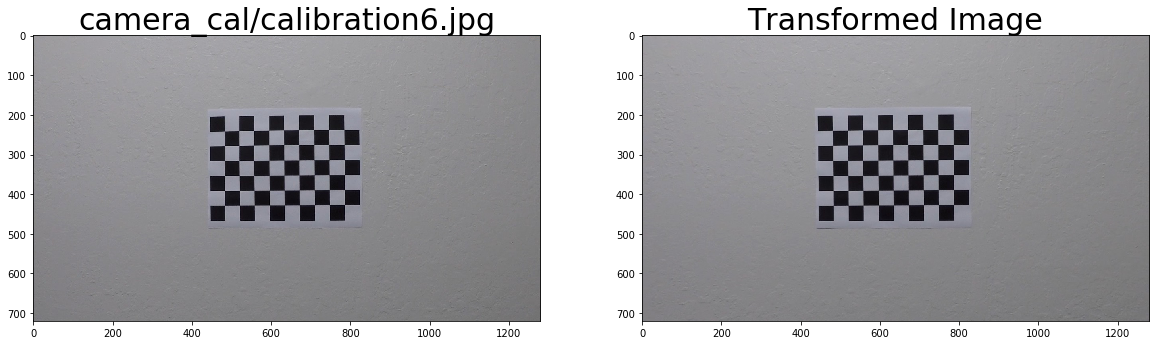

In [7]:
images = load_images(CAM_CAL)
visualize_transformation(images, UNDISTORT_TRANSFORM)

## Visualize Undistortion of test images

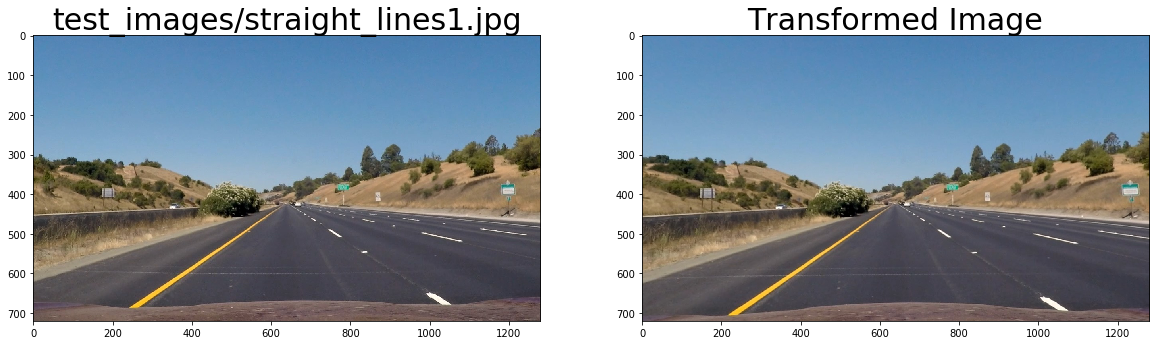

In [8]:
images = load_images(TEST)
visualize_transformation(images, UNDISTORT_TRANSFORM)


### Perspective Transform

In [9]:
def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (0,0,255), thickness= 4)
    #cv2.fillPoly(img, vertices, (0,0,255), lineType=8, shift=0)
    

def calc_perspective_window_points(img_height,img_width,x_center_adj=0):
    
    # calculator the vertices of the region of interest
    
    src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
        
    return src, dst

def perspective_transform(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

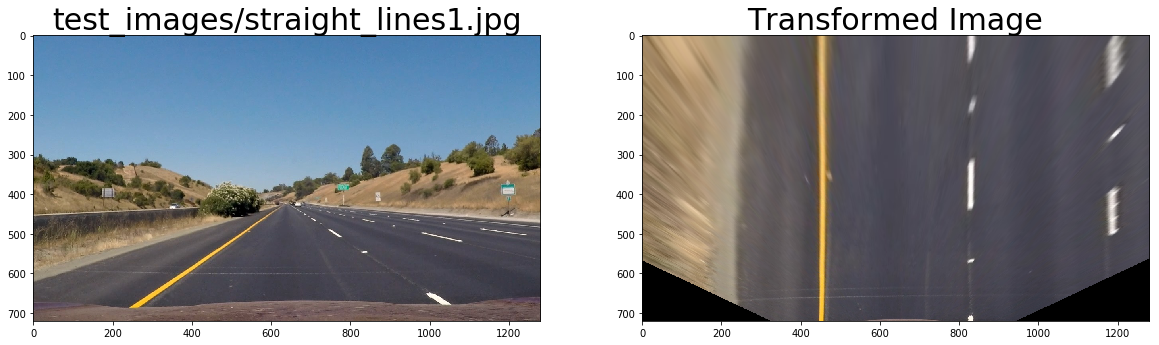

In [10]:
img = cv2.imread('test_images/test4.jpg')
h,w = img.shape[:2]

src, dst = calc_perspective_window_points(h, w)


images = load_images(TEST)
visualize_transformation(images, PERSPECTIVE_TRANSFORM, visualize_lines = False)

### Visualize multiple colorspace channels

In [11]:
def visualize_color_spaces(images):
    n = len(images)
    
    def view_img(i):
        file, img = images[i] 
        plt.imshow(img)
        undistorted_img = undistort_img(img)
        p_transformed_img, _, _ = perspective_transform(undistorted_img, src, dst)
        
        #RGB color space
        p_transformed_img_R = p_transformed_img[:,:,0]
        p_transformed_img_G = p_transformed_img[:,:,1]
        p_transformed_img_B = p_transformed_img[:,:,2]

        #HSV color space
        p_transformed_img_HSV = cv2.cvtColor(p_transformed_img, cv2.COLOR_RGB2HSV)
        p_transformed_img_H = p_transformed_img_HSV[:,:,0]
        p_transformed_img_S = p_transformed_img_HSV[:,:,1]
        p_transformed_img_V = p_transformed_img_HSV[:,:,2]
        
        #HLS color space
        p_transformed_img_HLS = cv2.cvtColor(p_transformed_img, cv2.COLOR_RGB2HLS)
        p_transformed_img_H2 = p_transformed_img_HLS[:,:,0]
        p_transformed_img_L = p_transformed_img_HLS[:,:,1]
        p_transformed_img_S2 = p_transformed_img_HLS[:,:,2]
        
        #YUV color space
        p_transformed_img_YUV = cv2.cvtColor(p_transformed_img, cv2.COLOR_RGB2YUV)
        p_transformed_img_Y = p_transformed_img_YUV[:,:,0]
        p_transformed_img_U = p_transformed_img_YUV[:,:,1]
        p_transformed_img_V2 = p_transformed_img_YUV[:,:,2]

        #LAB color space
        p_transformed_img_LAB = cv2.cvtColor(p_transformed_img, cv2.COLOR_RGB2Lab)
        p_transformed_img_L2 = p_transformed_img_LAB[:,:,0]
        p_transformed_img_A = p_transformed_img_LAB[:,:,1]
        p_transformed_img_B2 = p_transformed_img_LAB[:,:,2]

        plt.imshow(p_transformed_img)    
        fig, axs = plt.subplots(5,3, figsize=(16,12))
        fig.subplots_adjust(hspace = .8, wspace=.001)
        axs = axs.ravel()
        axs[0].imshow(p_transformed_img_R, cmap='gray')
        axs[0].set_title('RGB R-channel', fontsize=15)
        axs[1].imshow(p_transformed_img_G, cmap='gray')
        axs[1].set_title('RGB G-Channel', fontsize=15)
        axs[2].imshow(p_transformed_img_B, cmap='gray')
        axs[2].set_title('RGB B-channel', fontsize=15)
        
        axs[3].imshow(p_transformed_img_H, cmap='gray')
        axs[3].set_title('HSV H-Channel', fontsize=15)
        axs[4].imshow(p_transformed_img_S, cmap='gray')
        axs[4].set_title('HSV S-channel', fontsize=15)
        axs[5].imshow(p_transformed_img_V, cmap='gray')
        axs[5].set_title('HSV V-Channel', fontsize=15)
        
        axs[6].imshow(p_transformed_img_H2, cmap='gray')
        axs[6].set_title('HSV H-Channel', fontsize=15)
        axs[7].imshow(p_transformed_img_L, cmap='gray')
        axs[7].set_title('HSV L-channel', fontsize=15)
        axs[8].imshow(p_transformed_img_S2, cmap='gray')
        axs[8].set_title('HSV S-Channel', fontsize=15)
        
        axs[9].imshow(p_transformed_img_Y, cmap='gray')
        axs[9].set_title('YUV Y-Channel', fontsize=15)
        axs[10].imshow(p_transformed_img_U, cmap='gray')
        axs[10].set_title('YUV U-channel', fontsize=15)
        axs[11].imshow(p_transformed_img_V2, cmap='gray')
        axs[11].set_title('YUV V-Channel', fontsize=15)
        
        axs[12].imshow(p_transformed_img_L2, cmap='gray')
        axs[12].set_title('LAB L-channel', fontsize=15)
        axs[13].imshow(p_transformed_img_A, cmap='gray')
        axs[13].set_title('LAB A-Channel', fontsize=15)
        axs[14].imshow(p_transformed_img_B2, cmap='gray')
        axs[14].set_title('LAB B-Channel', fontsize=15)
    interact(view_img, i=(0,n-1))  

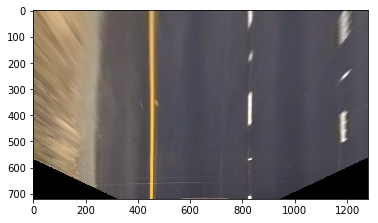

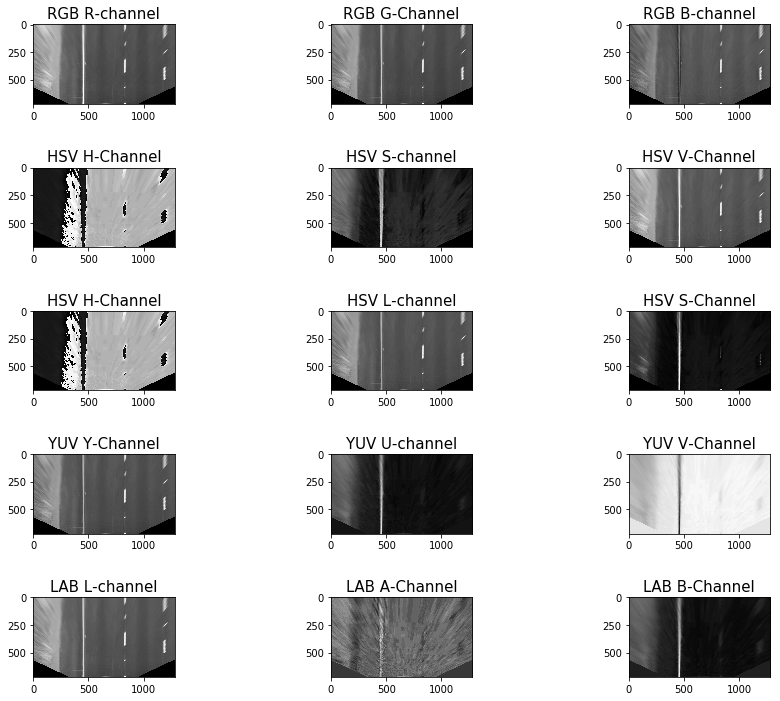

In [12]:
images = load_images(TEST)
visualize_color_spaces(images)

### Sobel Absolute Threshold

In [13]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

Visualize Sobel absolute threshold on example image

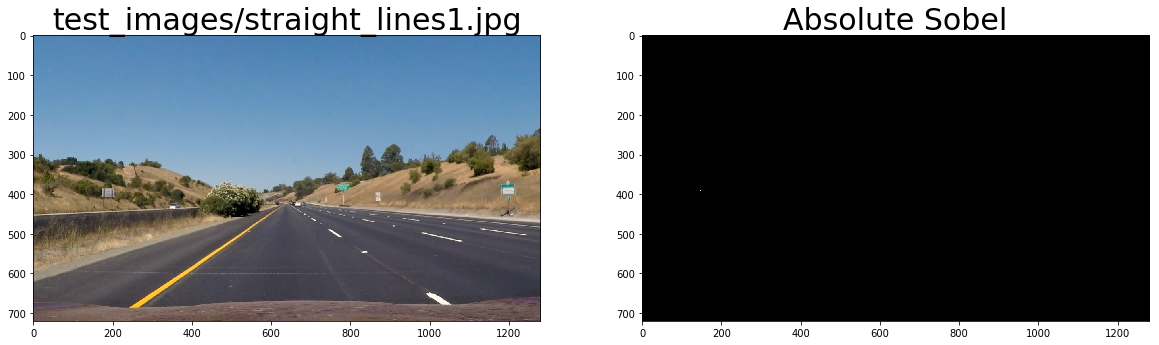

In [14]:
images = load_images(TEST)
visualize_transformation(images, SOBEL_ABSOLUTE_TRANSFORM)

### Sobel Magnitude Threshold

In [15]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output

Visualize Sobel magnitude threshold on example image

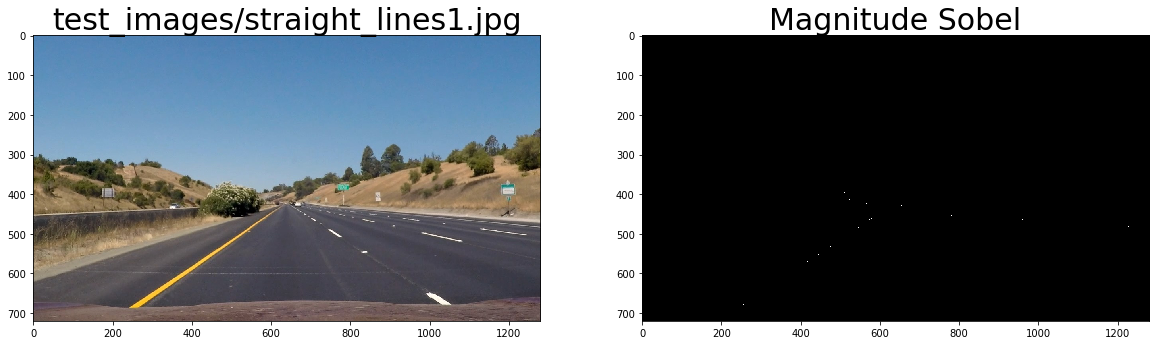

In [16]:
images = load_images(TEST)
visualize_transformation(images, SOBEL_MAGNITUDE_TRANSFORM)

### Sobel Direction Threshold

In [17]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

Visualize Sobel direction threshold on example image

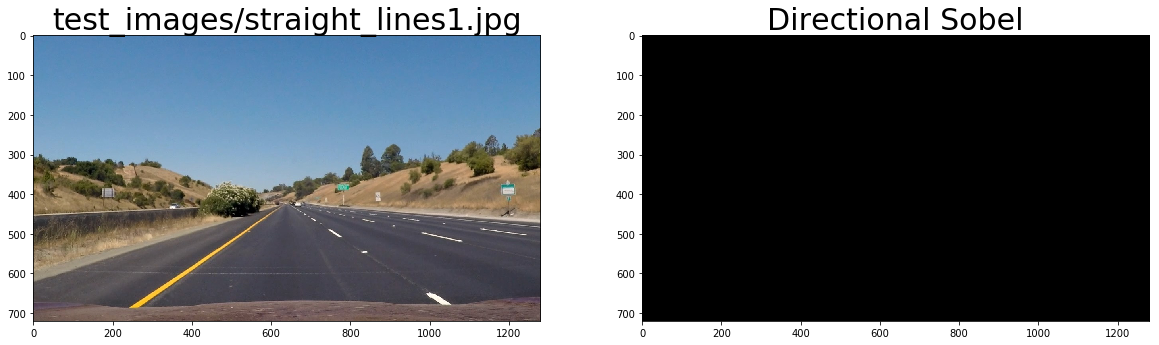

In [18]:
images = load_images(TEST)
visualize_transformation(images, SOBEL_DIRECTIONAL_TRANSFORM)

### Sobel Magnitude + Direction Threshold

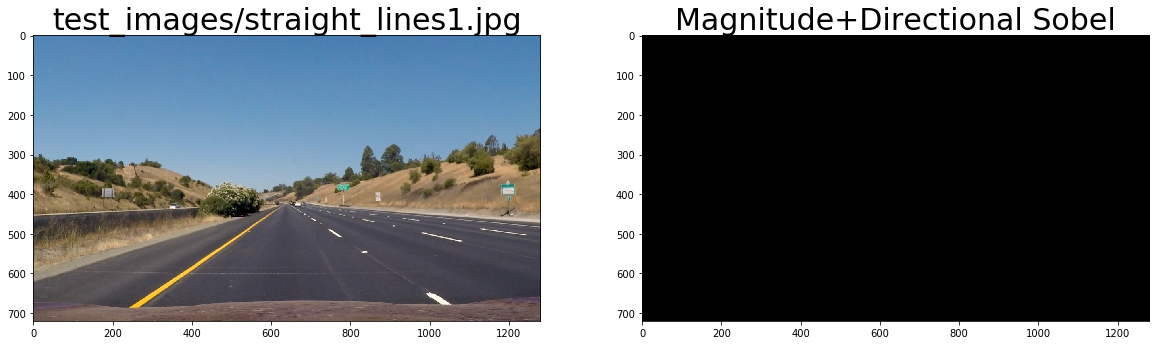

In [19]:
images = load_images(TEST)
visualize_transformation(images, SOBEL_COMBINED_TRANSFORM)

### HLS S-Channel Threshold

In [20]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

Visualize HLS S-Channel threshold on example image

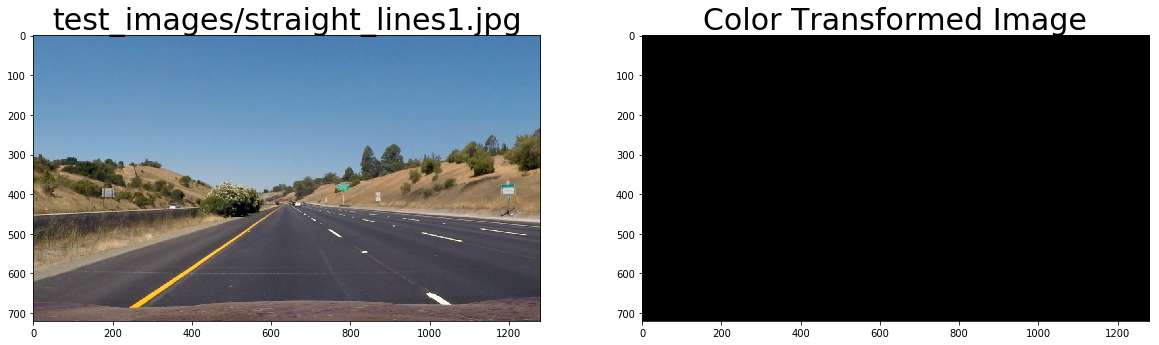

In [21]:
images = load_images(TEST)
visualize_transformation(images, HLS_S_TRANSFORM)

### HLS L-Channel

In [22]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

Visualize HLS L-Channel threshold on example image

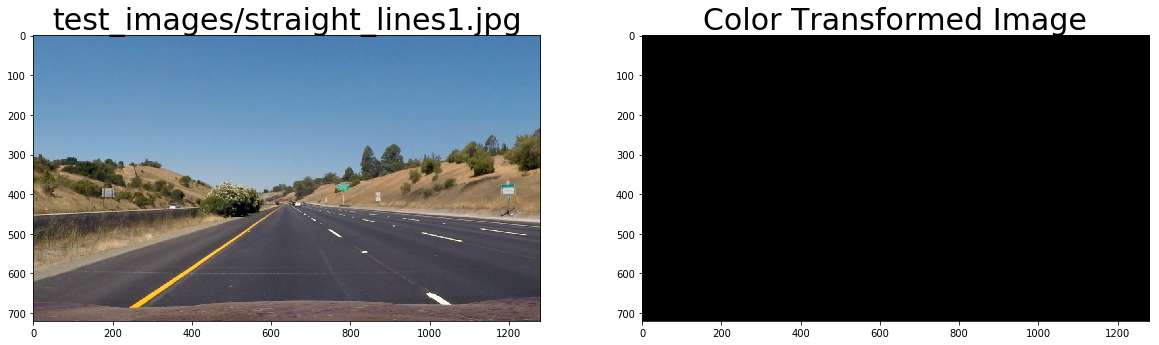

In [23]:
images = load_images(TEST)
visualize_transformation(images, HLS_L_TRANSFORM)

### LAB Colorspace

In [24]:
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

Visualize thresholding LAB colorspace on example image

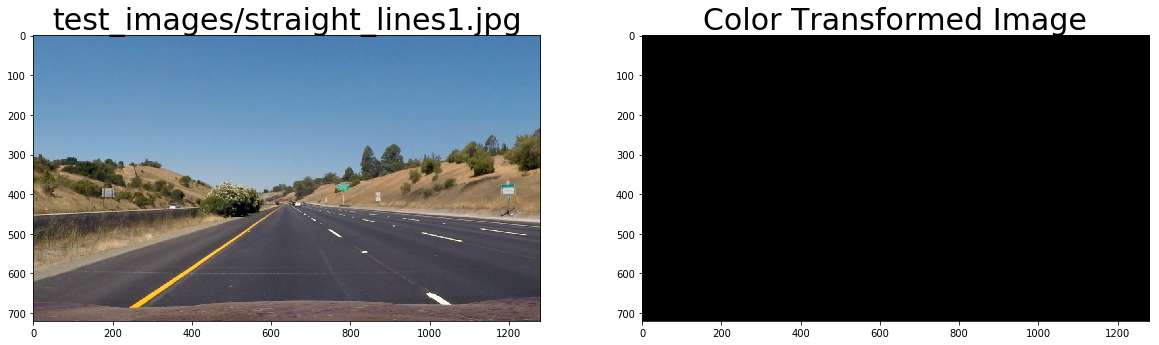

In [25]:
images = load_images(TEST)
visualize_transformation(images, LAB_B_TRANSFORM)

### Define Image Processing Pipeline

In [26]:
#pipeline to plot the lane lines after applying sobel and color transformations
def pipeline(img):
    # Undistort
    
    #print(img.shape)
    img_undistort = undistort_img(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = perspective_transform(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    img_sobelAbs = abs_sobel_thresh(img_unwarp)  

    # Sobel Magnitude (using default parameters)
    img_sobel_mag = mag_thresh(img_unwarp, mag_thresh= (31, 219))
    
    # Sobel Direction (using default parameters)
    img_sobel_dir = dir_thresh(img_unwarp, thresh = (0.45, 1.31))
    
    dst_img = np.zeros_like(img_sobel_mag)
    dst_img[((img_sobel_mag == 1) & (img_sobel_dir == 1) & (img_sobelAbs == 1))] = 1

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp, (210, 255))

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp, (180, 255))
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1) | (dst_img==1) ] = 1
    return combined, Minv

#pipeline to plot the lane lines after applying color transformations
def pipeline_color(img):
    # Undistort
    img_undistort = undistort_img(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = perspective_transform(img_undistort, src, dst)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

### Run Pipeline on All Test Images

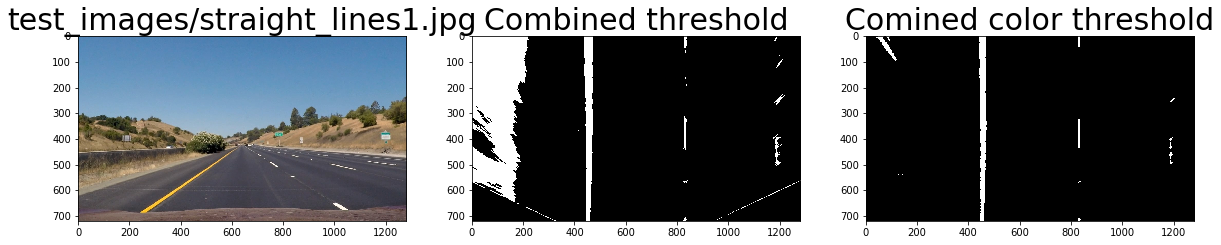

In [27]:
images = load_images(TEST)
visualize_transformation(images, PIPELINE_TRANSFORM)

## Fitting polynomial over detected lane lines

In [28]:
#method to get base points for left and right lanes
def get_lane_base_points(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram

    midpoint = np.int(histogram.shape[0]//2)
    
    #find a point between the extreme corners and the midpoint for lane recognition, ruling out 
    #errors due to noise on the sides on the lane
    quarter_point = np.int(midpoint//2)

    left_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    right_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    return left_base, right_base, histogram

# pipeline to fit polynomial to binary image with lines extracted
def lane_polyfit(img, nwindows = 20, window_width = 80, minpix = 40):
   
    #get base points for the left and right lane lines
    leftx_base, rightx_base, histogram = get_lane_base_points(img)

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
   
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
   
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - window_width
        win_xleft_high = leftx_current + window_width
        win_xright_low = rightx_current - window_width
        win_xright_high = rightx_current + window_width
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, 
                               win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & 
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    fit = (left_fit, right_fit)
    lane_indices = (left_lane_inds, right_lane_inds)
    
    return fit, lane_indices, visualization_data

## Visualize sliding window polyfit on example image

In [29]:
def plot_pipeline(img, draw_windows = True):
    
    fit, lane_indices, visualization_data = lane_polyfit(img)
    left_fit = fit[0]
    right_fit = fit[1]
    left_lane_inds = lane_indices[0]
    right_lane_inds = lane_indices[1]
    #left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(img)

    h = img.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    #print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if draw_windows is True:
        for rect in rectangles:
        # Draw the windows on the visualization image
            cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
            cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    return out_img, ploty, left_fit, right_fit, histogram

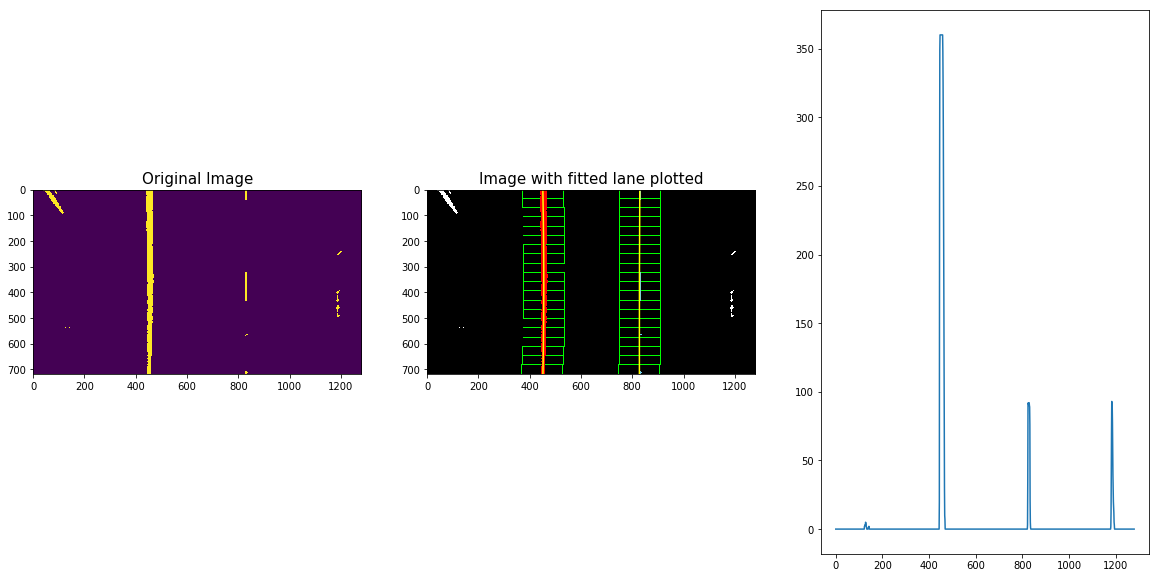

In [30]:
images = load_images(TEST)
visualize_transformation(images, PLOT_PIPELINE_TRANSFORM)

### Polyfit Using Fit from Previous Frame

*The test images test6, test4, and test5 appear, respectively, to be chronologically ordered frames from a single video capture*

In [31]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    fit_new = (left_fit_new, right_fit_new)
    lane_indices = (left_lane_inds, right_lane_inds)
    return fit_new, lane_indices

In [32]:
def plot_prev_fit_pipeline(img):
    
    img_bin, Minv = pipeline_color(img)   
    plt.imshow(img_bin, cmap='gray')
    margin = 80

    out_img, ploty, left_fit, right_fit, histogram = plot_pipeline(img_bin, draw_windows = False)
    fit2, lane_indices2 = polyfit_using_prev_fit(img_bin, left_fit, right_fit)
    
    left_fit2 = fit2[0] 
    right_fit2 = fit2[1]
    left_lane_inds2 = lane_indices2[0]
    right_lane_inds2 = lane_indices2[1]

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area (OLD FIT)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result, ploty, fit2

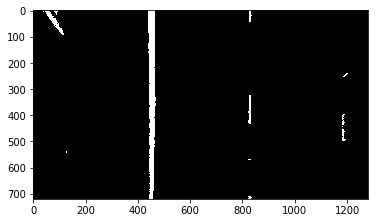

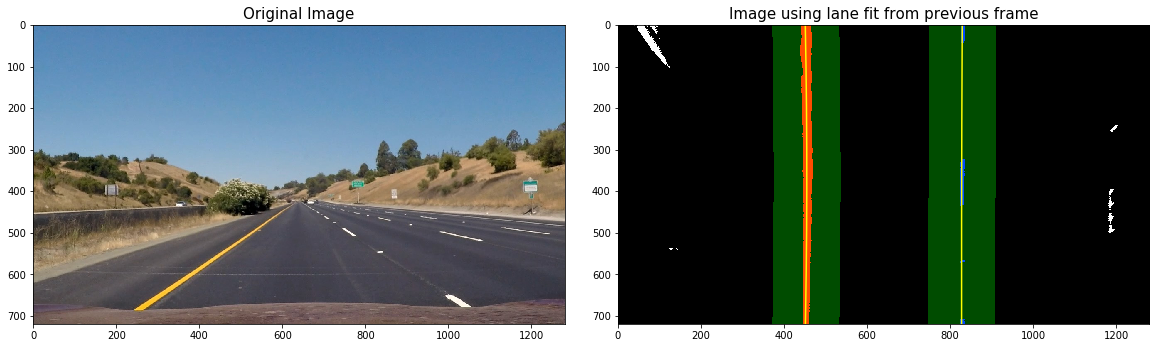

In [33]:
images = load_images(TEST)
visualize_transformation(images, PLOT_PREV_PIPELINE_TRANSFORM)

### Radius of Curvature and Distance from Lane Center Calculation

In [34]:
# Method to determine radius of curvature and distance from lane center 
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    
    # we will choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

### Calculate curvature radius and distance from center for example image

In [36]:
img = cv2.imread('./test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
img_bin, Minv = pipeline(img) 

fit, lane_inds, visualization_data = lane_polyfit(img_bin)
left_fit = fit[0]
right_fit = fit[1]
left_lane_inds = lane_inds[0]
right_lane_inds = lane_inds[1]
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center:', d_center, 'm')

Radius of curvature: 794.790541759 m, 221.173603254 m
Distance from lane center: -0.408962647191 m


### Draw the Detected Lane Back onto the Original Image

In [37]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

Draw detected lane onto example image

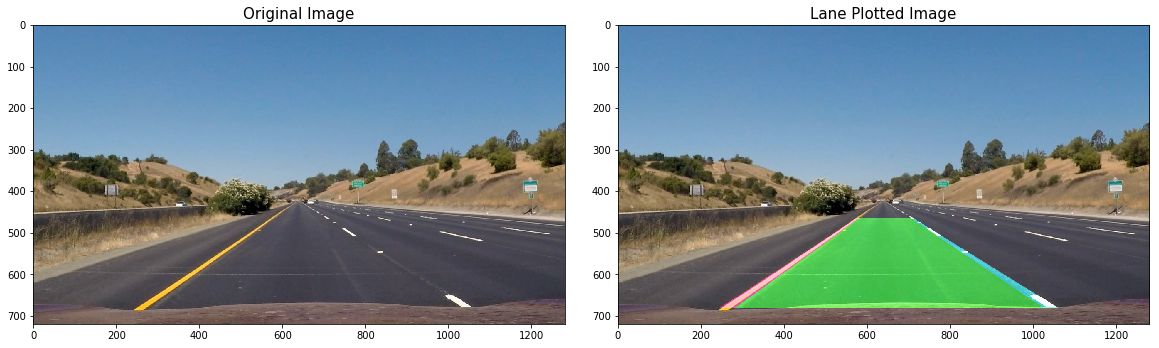

In [38]:
images = load_images(TEST)
visualize_transformation(images, PLOT_LANE_TRANSFORM)

### Draw Curvature Radius and Distance from Center Data onto the Original Image

In [39]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

Write data onto example image

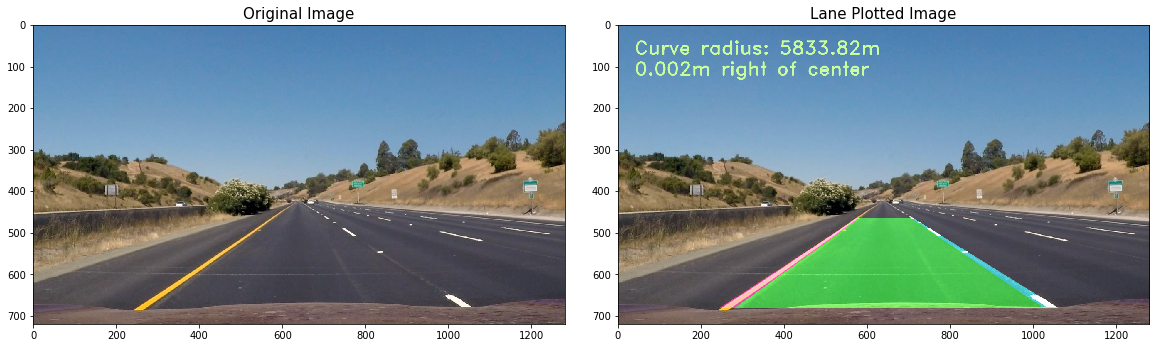

In [40]:
images = load_images(TEST)
visualize_transformation(images, PLOT_LANE_DATA_TRANSFORM)

### Define a Line Class for Storing Data

In [41]:
# Define a class to store properties of each line 
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.is_detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! 
                self.is_detected = False
            else:
                self.is_detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.is_detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

### Define Complete Image Processing Pipeline

In [42]:
#function to process image received from video
def process_image(img, lane_width = 350, max_tolerable_width_diff = 100):
    
    #make a copy of the original image
    new_img = np.copy(img)
    
    #apply undistortion and color thresholding on the image 
    img_bin, Minv = pipeline_color(new_img)
    
    # if both left and right lines were detected last frame, 
    # use polyfit_using_prev_fit, otherwise use sliding window fit
    if not l_line.is_detected or not r_line.is_detected:
        fit, lane_indices, visualization_data = lane_polyfit(img_bin)
    else:
        fit, lane_indices = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
    
    #unpack the left and right fits
    l_fit = fit[0]
    r_fit = fit[1]
    l_lane_inds = lane_indices[0]
    r_lane_inds = lane_indices[1]
    
    # invalidate both fits if the difference in their x-intercepts not around average lane width of 350px
    if l_fit is not None and r_fit is not None:
        
        # calculate x-intercept for fits
        h = img.shape[0]
        left_fit_x = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        right_fit_x = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        diff_x = abs(right_fit_x-left_fit_x)
        
        if abs(lane_width - diff_x) > max_tolerable_width_diff:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    return img_out

### Process Project Video

In [43]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output_color_pipeline.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output_color_pipeline.mp4
[MoviePy] Writing video project_video_output_color_pipeline.mp4


  2%|▏         | 20/1261 [00:02<02:24,  8.62it/s]

KeyboardInterrupt: 

### Process Challenge Video

In [ ]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output_color_pipeline.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

### Process Harder Challenge Video

In [ ]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)